In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
seed = 2022

import spacy
import pickle
nlp = spacy.load('en_core_web_md')

In [2]:
csv_file = "cleaned_EThOS_CSV_202210.csv"
df = pd.read_csv(csv_file, encoding="ISO-8859-2")
df.head()

/var/folders/l7/bnn1j6bs3bqfskq2jlq55yh80000gr/T/ipykernel_66473/740333908.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, encoding="ISO-8859-2")


,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
0,0,Computation and measurement of turbulent flow ...,,"Loizou, Panos A.",https://isni.org/isni/0000000136122593,,University of Manchester,https://isni.org/isni/0000000121662407,1989,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
1,1,Prolactin and growth hormone secretion in norm...,,"Prescott, R. W. G.",https://isni.org/isni/0000000134992122,,University of Newcastle upon Tyne,https://isni.org/isni/0000000104627212,1983,Thesis (Ph.D.),,Biological Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
2,2,Influence of strain fields on flame propagation,,"Mendes-Lopes, J. M. C.",https://isni.org/isni/0000000133937105,,University of Cambridge,https://isni.org/isni/0000000121885934,1983,Thesis (Ph.D.),Flame propagation can be highly influenced by ...,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
3,3,"Connectivity, flow and transport in network mo...",,"Robinson, Peter Clive",https://isni.org/isni/0000000135292822,,University of Oxford,https://isni.org/isni/0000000419368948,1984,Thesis (Ph.D.),In order to evaluate the safety of radioactive...,Physical Sciences,"Rae, John",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://ora.ox.ac.uk/objects/uuid:c61bf73b-b794...
4,4,The theory and implementation of a high qualit...,,"Lower, K. N.",https://isni.org/isni/0000000136133567,,University of Bristol,https://isni.org/isni/0000000419367603,1985,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,


In [3]:
# only consider the records with Subject Discipline and Abstracts
df_2 = df[(df["Subject Discipline"]!=" ") & (df["Abstract"]!= " ")]

In [4]:
len(df_2)

320527

In [7]:
# obtain abstract embeddings
abstract_docs = list(nlp.pipe(df_2["Abstract"], n_process=6)) 
abstract_embeddings = np.array([doc.vector for doc in abstract_docs])

# with open("spacy_abstract_embeddings.pkl", 'rb') as f:
#     embeddings = pickle.load(f)

In [8]:
# save the embeddings for later use
with open("spacy_abstract_embeddings.pkl", 'wb') as f:
    pickle.dump(abstract_embeddings, f)

In [9]:
labels = np.array(df_2["Subject Discipline"])
subjects = sorted(list(set(labels)))
label_index = [subjects.index(l) for l in labels]

In [12]:
subjects

['Agriculture & Veterinary Sciences',
 'Architecture, Building & Planning',
 'Biological Sciences',
 'Business & Administrative Studies',
 'Computer Science',
 'Creative Arts & Design',
 'Education',
 'Engineering & Technology',
 'History & Archaeology',
 'Language & Literature',
 'Law',
 'Librarianship & Information Science',
 'Mathematics & Statistics',
 'Medicine & Health',
 'Music',
 'Philosophy, Psychology & Religious Studies',
 'Physical Sciences',
 'Social, Economic & Political Studies',
 'Sport & Recreation']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(abstract_embeddings,
                                                    label_index,
                                                    random_state = seed)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(predictions, true, label_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    cm = confusion_matrix(true, predictions)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot(ax=ax,
                                                                             xticks_rotation="vertical")

## Decision Tree

Accuracy: 0.39160385364149153


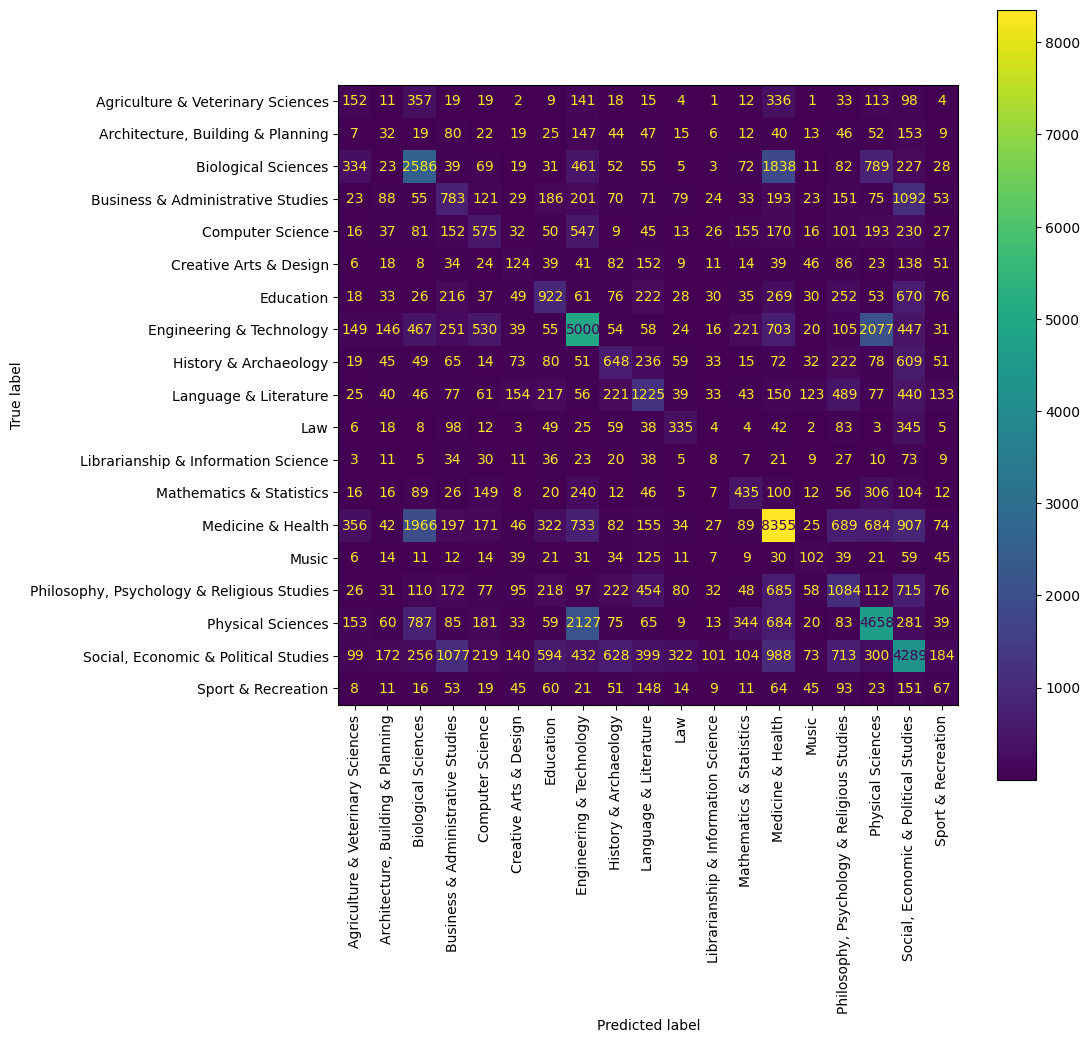

In [20]:
from sklearn.tree import DecisionTreeClassifier

# training a DescisionTreeClassifier
dtree_model = DecisionTreeClassifier().fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {dtree_model.score(X_test, y_test)}")

# creating a confusion matrix
plot_confusion_matrix(predictions = dtree_model.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## SVM

Accuracy: 0.6710926970498677


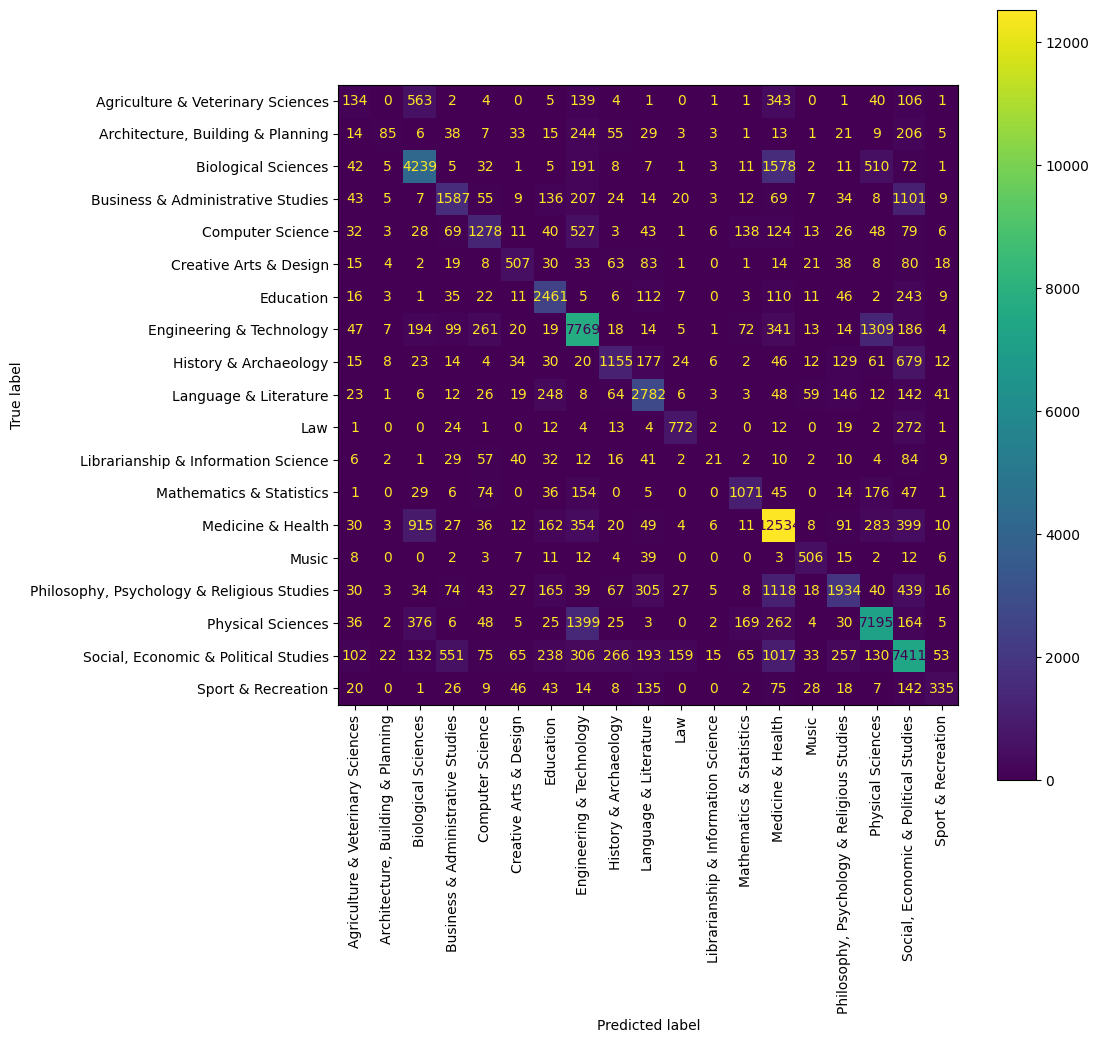

In [21]:
from sklearn.linear_model import SGDClassifier

# training a linear SVM classifier
svm_model_linear = SGDClassifier(loss='hinge',
                                 penalty='l2',
                                 alpha=1e-3,
                                 random_state=seed, 
                                 tol=None).fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {svm_model_linear.score(X_test, y_test)}")

# creating a confusion matrix
plot_confusion_matrix(predictions = svm_model_linear.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## Logistic regression

/Users/rchan/opt/miniconda3/envs/ethosTDSenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6774197574002895


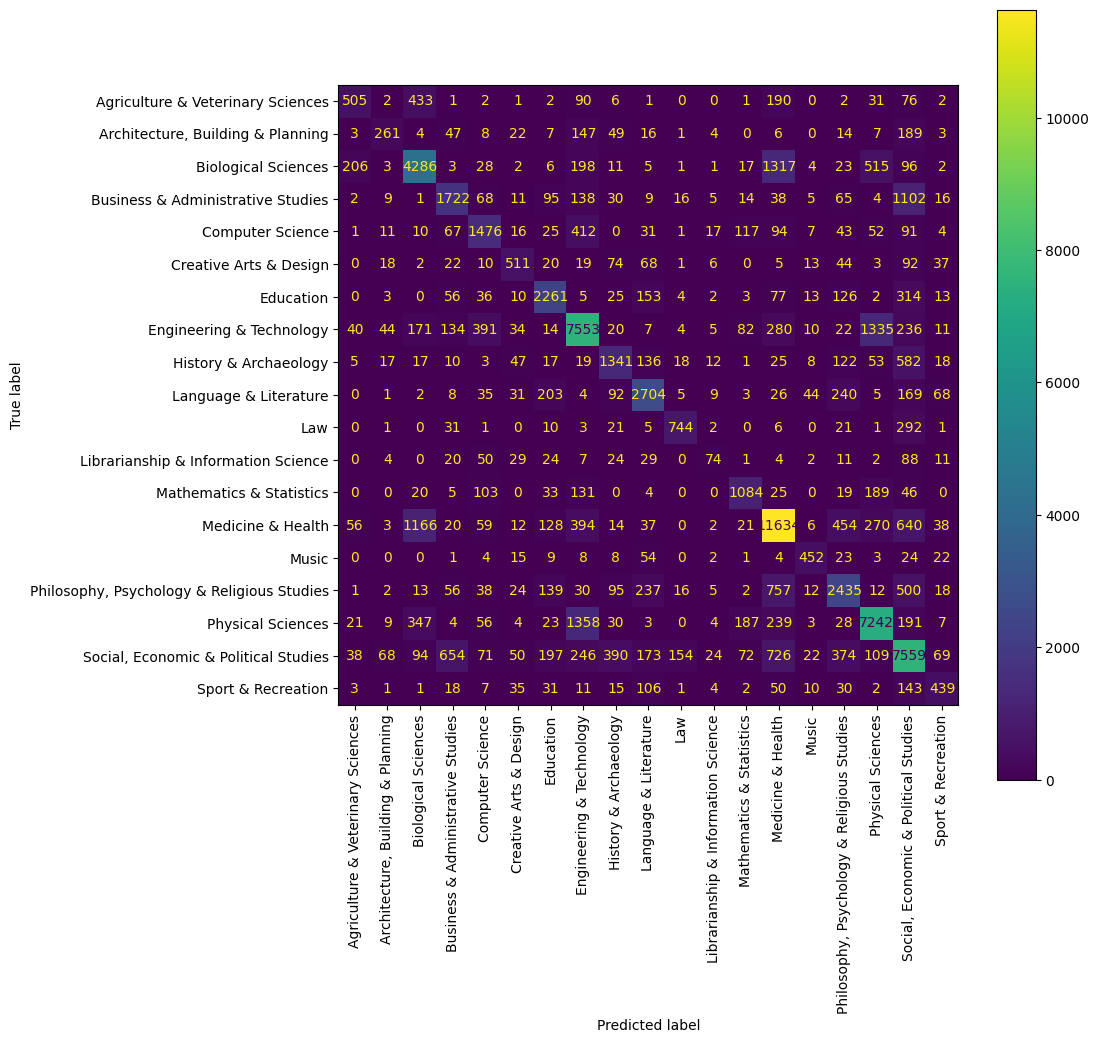

In [22]:
from sklearn.linear_model import LogisticRegression

# training a logistic regression classifier
log_reg_model_linear = LogisticRegression(penalty='l2',
                                          random_state=seed,
                                          max_iter=500,
                                          multi_class="multinomial").fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {log_reg_model_linear.score(X_test, y_test)}")

# creating a confusion matrix
plot_confusion_matrix(predictions = log_reg_model_linear.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## Logistic regression - binary for each class

/Users/rchan/opt/miniconda3/envs/ethosTDSenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6801153097389308


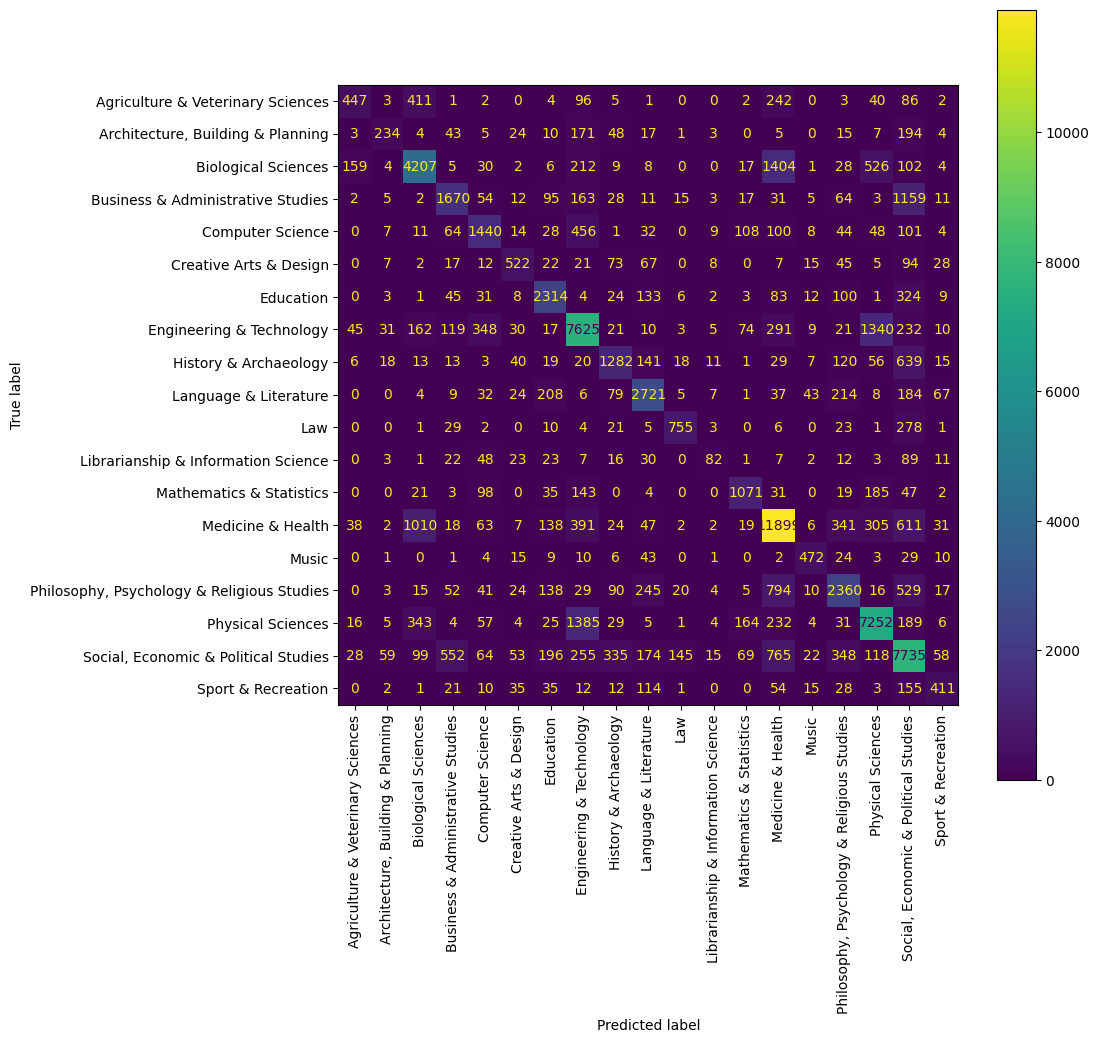

In [23]:
from sklearn.linear_model import LogisticRegression

# training a logistic regression classifier
log_reg_model_linear_2 = LogisticRegression(penalty='l2',
                                            random_state=seed,
                                            max_iter=200,
                                            multi_class="ovr").fit(X_train, y_train)

# model accuracy for X_test
print(f"Accuracy: {log_reg_model_linear_2.score(X_test, y_test)}")

# creating a confusion matrix
plot_confusion_matrix(predictions = log_reg_model_linear_2.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## KNN

Accuracy: 0.5884914890430789


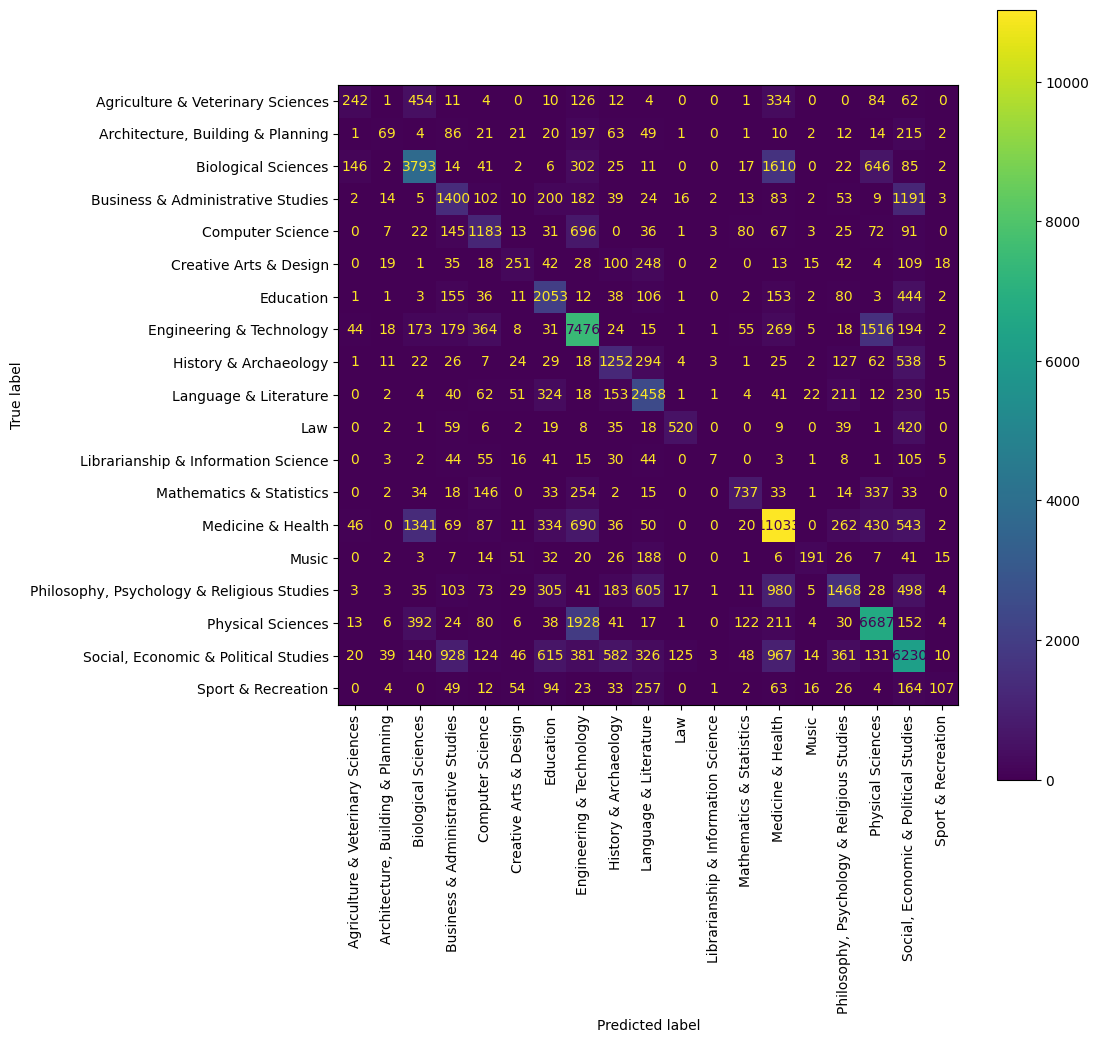

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# training a KNN classifier
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train)
  
# model accuracy for X_test
print(f"Accuracy: {knn.score(X_test, y_test)}")

# creating a confusion matrix
plot_confusion_matrix(predictions = knn.predict(X_test),
                      true = y_test,
                      label_names = subjects)

## Neural Network

In [28]:
import torch
import torch.nn as nn
from pytorch_utils import KFolds, set_seed, training_pytorch, testing_pytorch, KFold_pytorch
from ffn import FeedforwardNeuralNetModel

In [29]:
input_dim = abstract_embeddings.shape[1]
hidden_dim = 200
output_dim = len(subjects)
dropout_rate = 0.25
num_epochs = 100
learning_rate = 0.0005
n_folds = 5
patience = 2

In [31]:
data_folds = KFolds(x_data = torch.tensor(abstract_embeddings),
                    y_data = torch.tensor(label_index),
                    n_splits = n_folds,
                    shuffle = True,
                    random_state = seed)

In [32]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = nn.CrossEntropyLoss() # cross-entropy for creating confident models
# criterion = nn.NLLLoss() # negative log likelihood for multi-class classification
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate)

In [ ]:
kfold_eval = KFold_pytorch(data_folds,
                           model = model,
                           criterion = criterion,
                           optimizer = optimizer,
                           num_epochs = num_epochs,
                           verbose_args = {
                               "verbose": True,
                               "verbose_epoch": 10,
                               "verbose_item": 100000
                           })

  0%|                                                                                    | 0/5 [00:00<?, ?it/s]


**************************************************
Fold: 1 / 5
**************************************************



  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 || Item: 0/171802 || Loss: 2.8947947025299072
Epoch: 1/100 || Item: 100000/171802 || Loss: 1.4427083730697632
--------------------------------------------------
##### Epoch: 1/100 || Loss: 0.8527042269706726
--------------------------------------------------



  1%|▋                                                                      | 1/100 [03:00<4:57:47, 180.48s/it]

Epoch: 1 || Loss: 1.304282903317089 || Accuracy: 0.5856131315231323 || F1-score: 0.3961017656624469.



  4%|██▊                                                                    | 4/100 [11:56<4:47:18, 179.57s/it]